# Heartwood
> Supervised metric and not metric space learning methods for multiple purposes in Machine Learning

# TODO:
- [ ] Create SVD + KMeans Pipeline for clustering
- [X] Create Louvain + Dot Product in the node space pipeline for inference time

## What is it for?

- [X] supervised similarity matching
- [X] nomparametric density estimation
- [X] ensemble learning
- [X] Heterogeneous space clustering
- [X] Heterogeneous space embeddings
- [X] Heterogeneous space supervised embeddings

## Install

`pip install your_project_name`

## How to use

In [1]:
#hide
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

In [27]:
import seaborn as sns
from sklearn.datasets import fetch_california_housing

from heartwood.kernel import JaccardForestKernel, MLPKernel, DiscretizedTargetKernel, make_bimodal_assymetric_regression
from heartwood.utils import sparse_dot_product

In [41]:
X_bimodal, y_bimodal = make_bimodal_assymetric_regression(10_000)

In [42]:
housing = fetch_california_housing(as_frame = True)['frame']

In [43]:
numerical_cols = housing.columns[:-1]
target_col = housing.columns[-1]

In [44]:
housing

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


<AxesSubplot:xlabel='MedHouseVal', ylabel='Density'>

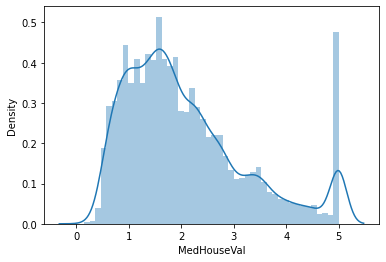

In [45]:
sns.distplot(housing.iloc[:,-1])

# JaccardForestKernel
> uses forest node embeddings and jaccard similarity to sample points

In [46]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, ExtraTreesClassifier, RandomForestClassifier, RandomTreesEmbedding, IsolationForest
from sklearn.model_selection import train_test_split

learner = JaccardForestKernel(
    RandomTreesEmbedding(500, n_jobs = -1),
    fit_neighbors_index = True,
    verbose = True
)

In [47]:
housing_train, housing_test = train_test_split(housing, train_size = 0.8)

In [48]:
learner.fit(
    housing_train[numerical_cols],
    housing_train[target_col],
    save_values = housing_train
)

JaccardForestKernel(estimator=RandomTreesEmbedding(n_estimators=500, n_jobs=-1),
                    verbose=True)

In [49]:
queries = learner.query(housing_test[numerical_cols])

kNN time total=2.079202 (sec), per query=0.000504 (sec), per query adjusted for thread number=0.002015 (sec)


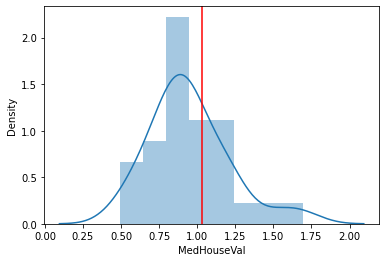

In [50]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.choice(len(housing_test))
q = queries[0][idx]
q['similarity'] = queries[1][idx]

sns.distplot(q[target_col])
plt.axvline(housing_test.iloc[idx][target_col], color = 'r')


In [51]:
q[:10]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,similarity
20086,2.5170,23.0,5.101604,1.024064,984.0,2.631016,37.99,-120.30,1.535,0.872659
9434,1.7614,25.0,5.194346,1.204947,706.0,2.494700,37.53,-120.19,0.713,0.855288
19585,2.3906,27.0,5.270270,1.022523,660.0,2.972973,37.59,-120.69,0.818,0.838235
20072,1.6021,29.0,4.560000,1.074545,1112.0,2.021818,37.98,-120.37,0.914,0.831502
19582,2.0385,25.0,5.021875,1.065625,2319.0,3.623438,37.65,-120.76,0.843,0.831502
9578,1.8939,28.0,5.711640,1.100529,1283.0,3.394180,37.26,-120.49,0.830,0.831502
19391,2.2679,25.0,3.971698,0.962264,303.0,2.858491,37.78,-120.85,0.713,0.821494
16399,2.4688,25.0,4.838816,0.986842,721.0,2.371711,38.00,-121.24,1.268,0.814882
20116,2.4922,19.0,5.238722,1.086466,1208.0,2.270677,37.95,-120.42,0.987,0.805054
9656,2.2794,23.0,5.763415,1.095122,1168.0,2.848780,36.99,-120.64,0.757,0.801802


In [52]:
#kng = learner.kneighbors_graph(mode = 'similarity')

# DiscretizedTargetKernel
> conditional target distribution could be bimodal, making regular regression faill. discretizing and running a classification might help

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [54]:
disc_learner = DiscretizedTargetKernel(
    estimator = make_pipeline(RobustScaler(), LogisticRegression()),
    n_bins = 15,
    strategy = 'uniform'
)


In [55]:
disc_learner.fit(
    housing_train[numerical_cols],
    housing_train[[target_col]],
    save_values = housing_train
)

DiscretizedTargetKernel(estimator=Pipeline(steps=[('robustscaler',
                                                   RobustScaler()),
                                                  ('logisticregression',
                                                   LogisticRegression())]),
                        n_bins=15, strategy='uniform')

In [56]:
disc_queries = disc_learner.query(housing_test[numerical_cols])

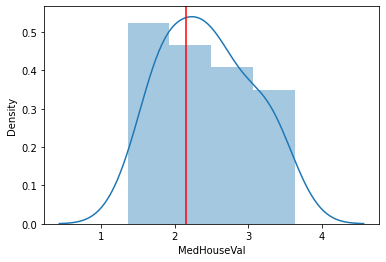

In [57]:
idx = np.random.choice(len(housing_test))
q = disc_queries[0][idx]
q['kldivergence'] = disc_queries[1][idx]

sns.distplot(q[target_col])
plt.axvline(housing_test.iloc[idx][target_col], color = 'r')


In [58]:
q[:10]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,kldivergence
1293,5.3245,8.0,5.987374,0.946970,1094.0,2.762626,38.00,-121.78,1.745,0.001972
1703,4.4911,20.0,5.906897,1.089655,1512.0,2.606897,37.97,-122.29,2.274,0.002050
19315,4.6705,19.0,6.389610,1.136364,852.0,2.766234,38.43,-122.91,2.698,0.002919
9341,4.1098,21.0,4.895323,1.028953,1100.0,2.449889,38.00,-122.60,2.466,0.003284
18397,4.5221,16.0,6.125000,1.159091,667.0,2.526515,37.22,-121.77,1.911,0.003692
1501,4.6602,22.0,5.767123,0.969863,993.0,2.720548,37.94,-122.05,2.278,0.003958
9763,4.2500,28.0,5.653295,0.982808,970.0,2.779370,36.47,-121.74,2.791,0.004107
18658,4.2006,24.0,5.972222,1.115079,1360.0,2.698413,36.98,-121.94,2.907,0.005113
19316,4.5110,22.0,5.631068,1.044660,1445.0,2.805825,38.40,-122.89,2.968,0.005502
19160,5.1966,15.0,6.426866,1.029851,979.0,2.922388,38.34,-122.63,3.254,0.005503


# Clustering

In [59]:
from sklearn.datasets import make_moons, make_blobs

<AxesSubplot:>

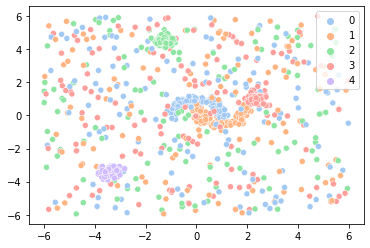

In [60]:
npoints = 500
nnoise = npoints//1
range_ = 5
moons, mlabels = make_moons(npoints//2, noise = 0.14)
blobs, blabels = make_blobs(npoints//2,cluster_std = 0.2, center_box = (-range_,range_), random_state = 42)
blabels = blabels + 2
noise = np.random.uniform(-(range_+1), range_+1, (nnoise,2))
nlabels = np.random.choice(range(blabels.max()), nnoise)

data = np.vstack([moons, noise, blobs])
labels = np.hstack([mlabels, nlabels, blabels])
sns.scatterplot(*data.T, alpha = 1, hue = labels, palette = 'pastel')


In [61]:
from sklearn.preprocessing import QuantileTransformer
isof = IsolationForest().fit(data)
iso_score_raw = isof.decision_function(data).reshape(-1,1)
isof_quant = QuantileTransformer()
isof_quant.fit(iso_score_raw)

iso_score_raw = iso_score_raw.reshape(-1,1)

def isof_to_weights(data, isof, isof_quant):
    iso_score_raw = isof.decision_function(data).reshape(-1,1)
    return np.where(iso_score_raw > 0, np.ones(iso_score_raw.shape), isof_quant.transform(iso_score_raw))


iso_score = isof_to_weights(data, isof, isof_quant)

clst = JaccardForestKernel(
    RandomForestClassifier(
        100,
        max_depth = None,
        min_samples_leaf = 2,
        n_jobs = -1,                
    ),
    fit_neighbors_index = False
)

clst.fit(data, labels)

JaccardForestKernel(estimator=RandomForestClassifier(min_samples_leaf=2,
                                                     n_jobs=-1),
                    fit_neighbors_index=False)

# Louvain Space Partition

In [62]:
from sklearn.ensemble import IsolationForest
from sknetwork.embedding import GSVD, Spectral, SVD, PCA, RandomProjection, LouvainEmbedding, LouvainNE, ForceAtlas
from sknetwork.clustering import Louvain, PropagationClustering, KMeans
from sknetwork.ranking import PageRank
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import dbscan
from sklearn.preprocessing import QuantileTransformer
from karateclub import BigClam
import hdbscan

#kng = clst.kneighbors_graph()
#kng = kng.multiply(1/kng.sum(axis = 1)).tocsr()
#embs = Louvain().fit_transform(kng)
#embeder = LouvainEmbedding(n_aggregations = -1).fit(clst.transform(data))

#clusters = Louvain(1).fit(clst.transform(data))


#iso_score = np.exp(iso_score_raw.reshape(-1,1))

#rank = PageRank().fit(clst.transform(data).multiply(iso_score).tocsr())
#embeder = LouvainEmbedding(1).fit(clst.transform(data))
embeder = Louvain(1).fit(clst.transform(data))
#embeder = LouvainEmbedding(1).fit(clst.transform(data).multiply(iso_score.reshape(-1,1)).tocsr())
#embeder = LouvainEmbedding(2).fit(clst.transform(data).multiply(rank.scores_col_.reshape(1,-1)).tocsr())
#clusters = Louvain(1).fit(kng)
#embeder = LouvainEmbedding().fit(kng)

#db = hdbscan.HDBSCAN().fit(data)
#db = db.labels_

#embeder = TruncatedSVD().fit(learner.transform(housing_train[numerical_cols]))

In [63]:
embs = awesome_cossim_topn(clst.transform(data), sparse.csr_matrix(embeder.embedding_col_), embeder.embedding_col_.shape[-1], lower_bound = 0).A/100

NameError: name 'awesome_cossim_topn' is not defined

In [ ]:
sns.distplot(embs.max(1)[iso_score.flatten() == 1])
sns.distplot(embs.max(1)[iso_score.flatten() < 1])

In [ ]:
embeder.embedding_col_.shape

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

test_data = data#np.random.uniform(-(range_+3), range_+3, (10000,2))

embs = sparse_dot_product(clst.transform(test_data), sparse.csr_matrix(embeder.embedding_col_), 100)
#clusters = OneHotEncoder().fit_transform(np.argmax(embs, 1).reshape(-1,1))
clusters = np.argmax(embs, 1).A.flatten()
#embs = embeder.embedding_
embs = embs/embs.sum(axis = 1).reshape(-1,1)
embs = embs.A
#sns.distplot(embs)

In [ ]:
#%%timeit
from scipy.stats import entropy
iso_score_test = isof_to_weights(test_data, isof, isof_quant)

msk = clusters == 3
louvain_labels = embs.argmax(1)
entropies = -np.exp(entropy(embs ,axis = 1))
entropies = embs.max(1).flatten()
entropies = (entropies - entropies.min())/(entropies.max() - entropies.min())



sns.scatterplot(
    *test_data.T,
    hue = louvain_labels,
    palette = 'tab20',
    #hue = embs.max(1) < 0.8,    
    alpha = embs.max(1),
    
)
#sns.scatterplot(
#    *data.T,        
#    alpha = 1
#)


# Leiden Space Partition

In [ ]:
len(list(nx.algorithms.connected_components(G)))

In [ ]:
import csrgraph as cg
import networkx as nx
from sknetwork.utils import bipartite2undirected, bipartite2directed
from cdlib.algorithms import leiden
G = bipartite2undirected(clst.transform(data), )
G = nx.from_scipy_sparse_matrix(G)
#G = cg.csrgraph(G)
bigc = leiden(G)
#bigc.fit(G)

In [ ]:
clusters_leiden = np.vstack([np.hstack([np.array(bigc.communities[i]).reshape(-1,1), np.ones((len(bigc.communities[i]),1))*i]) for i in range(len(bigc.communities))]).astype(int)
clusters_leiden = clusters_leiden[np.argsort(clusters_leiden[:,0])][:,1:2]
clusters_leiden

In [ ]:
#len(list(nx.algorithms.components.connected_components(nx.from_scipy_sparse_matrix(G))))

In [ ]:
n_points, n_nodes = clst.transform(data).shape
node_embs = clusters_leiden[n_points:]
node_embs = OneHotEncoder().fit_transform(node_embs)

In [ ]:
node_embs = awesome_cossim_topn(clst.transform(data), sparse.csr_matrix(node_embs), 100)
node_embs = node_embs.A/100

In [ ]:
node_embs.shape
clusters = clusters_leiden[:n_points]

In [ ]:
sns.distplot(node_embs.max(1))

In [ ]:
#samples = G.random_walks(10, 30, [1,14], return_weight = 1.)
#msk = samples <= n_points
#samples = [i[i <= n_points] for i in samples]
#samples = np.array(samples)
#idx, cts = np.unique(samples, return_counts = True)
#idx = idx
#alpha = (cts - cts.min())/(cts.max() - cts.min())

#sns.scatterplot(*data[idx].T, alpha = alpha)
#plt.plot(*data[samples].T)
sns.scatterplot(
    *data.T,
    alpha = node_embs.max(1),
    palette = 'tab20',
    #hue = node_embs.max(1) < .8,
    hue = clusters.flatten(),
    
)